## This is the refined version of the DataCamp Professional Data Scientist Case Study

### Import the necessary libaries...


In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as met
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, VotingClassifier, AdaBoostClassifier
#from sklearn.inspection import plot_partial_dependence

### ... and the data too

In [2]:
df = pd.read_csv('event_venues.csv')

Viewing the data generally, is there a missing point somewhere?

In [3]:
print(df.isna().sum())

venue_name                    0
Loud music / events           0
Venue provides alcohol        0
Wi-Fi                         0
supervenue                    0
U-Shaped_max                  0
max_standing                  0
Theatre_max                   0
Promoted / ticketed events    0
Wheelchair accessible         0
dtype: int64


Apparently, there is no missing data. Good enough.

How does the data look?

In [21]:
display(df.head())
print(df.info())
print(df.describe())

,venue_name,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,U-Shaped_max,max_standing,Theatre_max,Promoted / ticketed events,Wheelchair accessible
0,techspace aldgate east,False,0,True,False,35.045455,0,112.715867,False,False
1,green rooms hotel,True,1,True,False,40.000000,120,80.000000,True,False
2,148 leadenhall street,False,0,True,False,35.045455,0,112.715867,False,False
3,conway hall,False,0,True,False,35.045455,60,60.000000,False,False
4,gridiron building,False,0,True,False,35.045455,0,112.715867,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3910 entries, 0 to 3909
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   venue_name                  3910 non-null   object 
 1   Loud music / events         3910 non-null   bool   
 2   Venue provides alcohol      3910 non-null   int64  
 3   Wi-Fi                       3910 non-null   bool   
 4   supervenue                  3910 non-null   bool   
 5   U-Shaped_max                3910 non-null   float64
 6   max_standing                3910 non-null   int64  
 7   Theatre_max                 3910 non-null   float64
 8   Promoted / ticketed events  3910 non-null   bool   
 9   Wheelchair accessible       3910 non-null   bool   
dtypes: bool(5), float64(2), int64(2), object(1)
memory usage: 172.0+ KB
None
       Venue provides alcohol  U-Shaped_max  max_standing  Theatre_max
count             3910.000000   3910.000000   3910.000000  3

3910 entries and 10 columns (one of which is the target vector)

### VENUE NAME

The venue name may not contain so much information that other columns cannot reflect. This is pure assumption (and maybe a bit of domain knowledge.) We can model a way of finding out if the names matter later.

In [4]:
df['venue_name'].value_counts()

radisson blu edwardian heathrow    27
bma house                          24
friends house                      23
henry wood house                   19
30 euston square                   18
                                   ..
sailing barge will                  1
vip bus bars                        1
the prince west brompton            1
bizspace camberwell                 1
hard rock cafe oxford street        1
Name: venue_name, Length: 1444, dtype: int64

Some venues occur more than once. Maybe we should try and drop duplicate rows.

In [5]:
df.drop_duplicates(inplace=True)

Now, we check the shape again...

In [6]:
df.shape

(3460, 10)

... and 3460 rows are left...

In [7]:
df['venue_name'].value_counts()

bma house                                  22
radisson blu edwardian heathrow            18
friends house                              17
twickenham stadium                         13
henry wood house                           12
                                           ..
icetank studios                             1
dot athena                                  1
k arc studio                                1
the loft - w. epic roof terrace & views     1
hard rock cafe oxford street                1
Name: venue_name, Length: 1444, dtype: int64

...and some venues still get repeated. Let's assume that they are venues with the same names in different places.

### LOUD MUSIC/EVENTS

In [9]:
df['Loud music / events'].sum()

1323

1323 venues allow loud events. A plot will do better here...

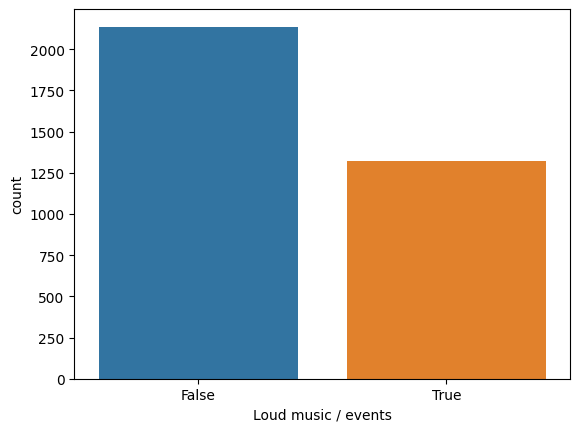

In [10]:
sns.countplot(data=df, x='Loud music / events')
plt.show()

### VENUE PROVIDES ALCOHOL

In [16]:
df['Venue provides alcohol']

0       0
1       1
2       0
3       0
4       0
       ..
3904    1
3905    1
3906    0
3907    1
3909    0
Name: Venue provides alcohol, Length: 3460, dtype: int64

This again is a Yes-No column. Let the chart speak for itself

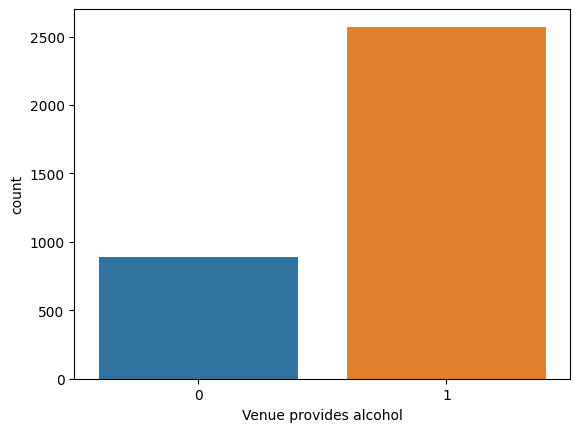

In [18]:
sns.countplot(data=df, x='Venue provides alcohol')
plt.show()

Obviously, more venues provide alcohol than not.

### Wi-Fi

In [19]:
df['Wi-Fi']

0        True
1        True
2        True
3        True
4        True
        ...  
3904    False
3905     True
3906     True
3907     True
3909     True
Name: Wi-Fi, Length: 3460, dtype: bool

Yet another boolean column. Isn't this the third one or so?

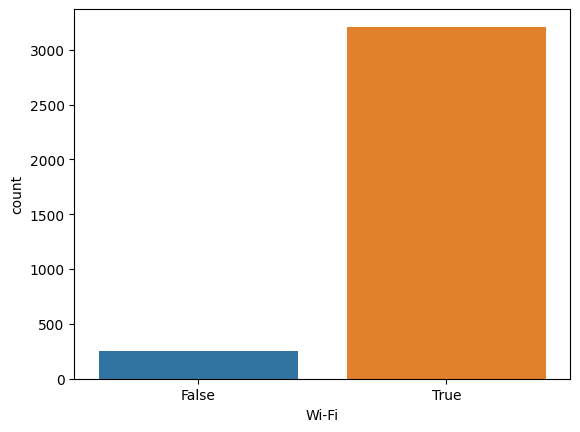

In [20]:
sns.countplot(data=df, x='Wi-Fi')
plt.show()

So nice that most event centre owners make Wi-Fi available.

### supervenue

In [21]:
df['supervenue']

0       False
1       False
2       False
3       False
4       False
        ...  
3904    False
3905    False
3906    False
3907    False
3909    False
Name: supervenue, Length: 3460, dtype: bool

Seems we have to deal with a lot of boolean columns on this one

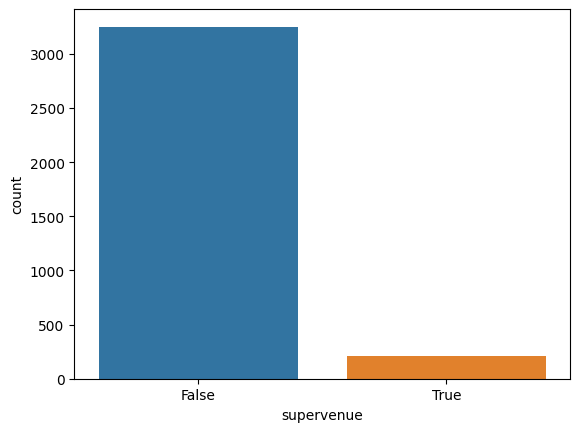

In [22]:
sns.countplot(data=df, x='supervenue')
plt.show()

Contrary to asssumptions, many of our venues are not even supervenues. _I read something about supervenues changing every week. If that is true, then it must be removed as it may not be a strong predictor of our target. By the way, is a wheel-chair ramp a condition for being a supervenue? If yes, I think ALL supervenues should have ramps._

In [23]:
# df['supervenue'].corr(df['Wheelchair accessible'])

supervenue = df[df['supervenue'] == True].shape[0]
non_supervenue = df[df['supervenue'] == False].shape[0]

supervenue_and_wheelchair_accessible = df[(df['supervenue'] == True) & (df['Wheelchair accessible'] == True)].shape[0]
supervenue_and_not_wheelchair_accessible = df[(df['supervenue'] == True) & (df['Wheelchair accessible'] == False)].shape[0]

non_supervenue_and_wheelchair_accessible = df[(df['supervenue'] == False) & (df['Wheelchair accessible'] == True)].shape[0]
non_supervenue_and_not_wheelchair_accessible = df[(df['supervenue'] == False) & (df['Wheelchair accessible'] == False)]


print(supervenue_and_wheelchair_accessible * 100 / supervenue, '% of supervenues are wheelchair accessible' )
print(non_supervenue_and_wheelchair_accessible * 100 / non_supervenue, '% of non_supervenues are wheelchair accessible')

30.28846153846154 % of supervenues are wheelchair accessible
53.505535055350556 % of non_supervenues are wheelchair accessible


But that seems untrue. In fact, the percentage of supervenues with ramp is considerably lesser than the percentage of non-supervenues with ramps. Many things could have skewed the number but we know that having a ramp is not required to be a supervenue.

Let the diagram tell the story.

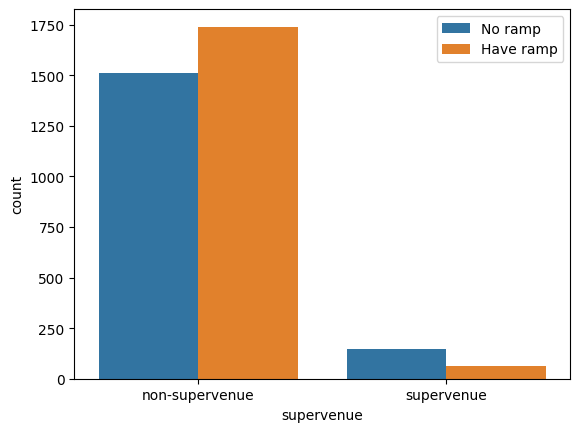

In [27]:
sns.countplot(data=df, x='supervenue', hue='Wheelchair accessible')
plt.xticks([0, 1],['non-supervenue', 'supervenue'])
plt.legend(['No ramp', 'Have ramp'])
plt.show()

In [29]:
df['supervenue'].corr(df['Wheelchair accessible'])

-0.11047278304412156

In fact, there is a negative correlation between being a supervenue and having ramps. Authorities should look into this.

### U-Shaped_max

In [30]:
df['U-Shaped_max']

0       35.045455
1       40.000000
2       35.045455
3       35.045455
4       35.045455
          ...    
3904    35.045455
3905    40.000000
3906    28.000000
3907    13.000000
3909    28.000000
Name: U-Shaped_max, Length: 3460, dtype: float64

This is a numeric column. We expect the values to be integral since we are talking about human beings. But it is observable that some entries are float. I guess they are corrupted. We have to use some domain knowledge to replace them or just remove them altogether.

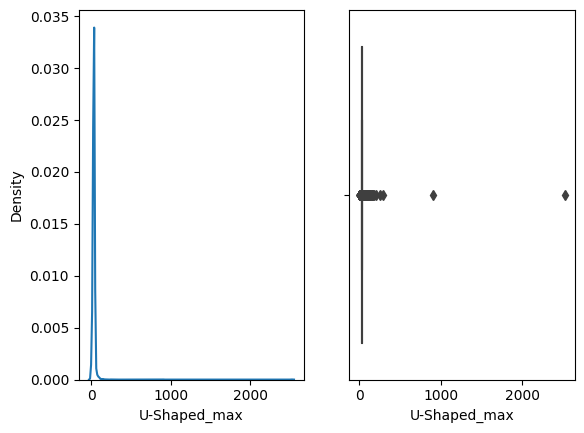

In [41]:
fig, ax = plt.subplots(1, 2)
sns.kdeplot(data=df, x='U-Shaped_max', ax=ax[0])
sns.boxplot(data=df, x='U-Shaped_max', ax=ax[1])
plt.show()


It is obvious that there extremely large U-Shaped theatres. It is either they are really large or they are just mistakes. If they are really large, then other values should also be large.

It is not just that there are crazily large values, there are ridicoulously small ones. 

In [69]:
df[df['U-Shaped_max'] < 15].shape

(155, 10)

155 entries are below 15 people capacity. That is ridiculous.

Let's check if the venues are really small or they are just errors


In [93]:
small_U_shaped_max = df[df['U-Shaped_max'] < 15]
display(small_U_shaped_max[['U-Shaped_max', 'max_standing', 'Theatre_max']].sort_values('U-Shaped_max').head(10))
display(small_U_shaped_max.describe(percentiles=[0.05, .1, .15, .2, .3, .5, .6, .9]))

,U-Shaped_max,max_standing,Theatre_max
3771,1.0,100,1.000000
249,2.0,3,2.000000
29,4.0,10,112.715867
2979,4.0,5,5.000000
900,4.0,4,112.715867
489,4.0,0,112.715867
459,4.0,4,112.715867
484,5.0,0,15.000000
701,5.0,8,112.715867
824,6.0,45,35.000000


,Venue provides alcohol,U-Shaped_max,max_standing,Theatre_max
count,155.000000,155.000000,155.000000,155.000000
mean,0.593548,10.290323,17.554839,48.807832
std,0.492763,2.934275,25.139647,42.045762
min,0.000000,1.000000,0.000000,1.000000
5%,0.000000,5.000000,0.000000,10.000000
10%,0.000000,6.000000,0.000000,12.000000
15%,0.000000,7.100000,0.000000,12.200000
20%,0.000000,8.000000,0.000000,15.800000
30%,0.000000,9.000000,0.000000,20.000000
50%,1.000000,10.000000,10.000000,25.000000


Looking at these rows, it is evident that the low values are errors. As a means of cross-check, shall we scatter-plot these columns with each other and see if any correlation exists.

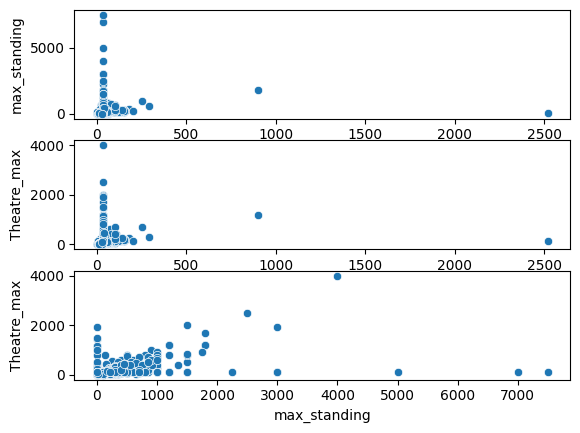

In [96]:
a = 'U-Shaped_max'
b = 'max_standing'
c = 'Theatre_max'

fig, ax = plt.subplots(3, 1)
sns.scatterplot(data=df, x=a, y=b, ax=ax[0])
sns.scatterplot(data=df, x=a, y=c, ax=ax[1])
sns.scatterplot(data=df, x=b, y=c, ax=ax[2])
plt.show()

There is no real relationship between these values. Wow!

Before we forget let's see how many rows are non-integral numbers

In [ ]:
g = 400.0001

def is_whole(g):
    # This function checks if a number is whole or not, despite if it has decimal point or not.
    meji = str(g).split('.')
    if int(meji[1]) == 0:
        return True
    else:
        return False
    
is_whole(g)

False

In [63]:
count = 0
idx = []
for i in df['U-Shaped_max']:
    if is_whole(i) == False:
        count = count+1
        idx.append(i)
print(count)
print(idx[:10])

2514
[35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455, 35.04545454545455]


There is something wrong with this column. 2514 entries are truncated. That is too much to be filled in with another general figure. Our model is basically going to memorize this value.

### max_standing

In [97]:
df['max_standing']

0         0
1       120
2         0
3        60
4         0
       ... 
3904    220
3905    450
3906      0
3907     20
3909      0
Name: max_standing, Length: 3460, dtype: int64

Many of these rows are 0. That may be explicable. Some venues do not have standing space at all.

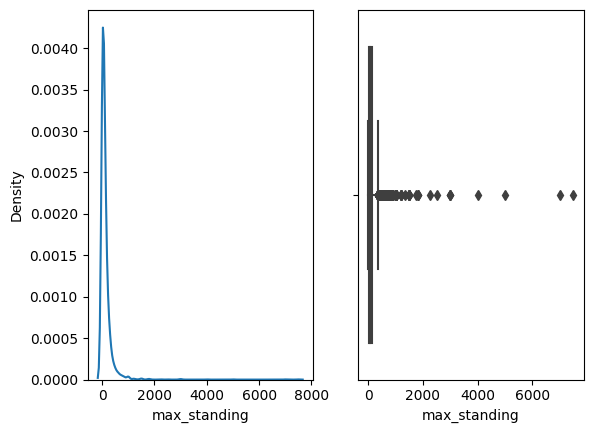

In [98]:
fig, ax = plt.subplots(1, 2)
sns.kdeplot(data=df, x='max_standing', ax=ax[0])
sns.boxplot(data=df, x='max_standing', ax=ax[1])
plt.show()


Again, outliers are here. But the curve seems smooth. Let's dig deep

First, once bitten twice shy. We need to be sure if there are non-whole numbers here too. We see from th columns info that this column contains integers. This is comforting.

Second, why the outliers?

In [102]:
df['max_standing'].describe(percentiles=[.01, .05, .1, .2, .3, .4, .9, .95, .99, .999])

count    3460.000000
mean      126.390462
std       285.898114
min         0.000000
1%          0.000000
5%          0.000000
10%         0.000000
20%         5.000000
30%        25.000000
40%        40.000000
50%        60.000000
90%       300.000000
95%       421.000000
99%      1000.000000
99.9%    3541.000000
max      7500.000000
Name: max_standing, dtype: float64

Taking the assumption that 0 standing space is agreeable, what about the top 1% that have over 1000 standing space. Are they fields? Are they really big?

In [104]:
print('There are',df[df['max_standing'] >1000].shape[0],'venues that have over 1000 standing space')

There are 25 venues that have over 1000 standing space


In [106]:
large_standing_space = df[df['max_standing'] > 1000]
display(large_standing_space[['U-Shaped_max', 'max_standing', 'Theatre_max']].sort_values('max_standing'))
display(large_standing_space.describe())

,U-Shaped_max,max_standing,Theatre_max
2045,35.045455,1200,800.000000
2220,35.045455,1200,1200.000000
3210,35.045455,1200,112.715867
2806,35.045455,1200,112.715867
2780,35.045455,1200,1200.000000
2902,35.045455,1350,400.000000
3675,35.045455,1500,112.715867
3542,35.045455,1500,800.000000
3309,35.045455,1500,500.000000
3813,35.045455,1500,820.000000


,Venue provides alcohol,U-Shaped_max,max_standing,Theatre_max
count,25.000000,25.000000,25.000000,25.000000
mean,0.840000,69.643636,2430.000000,889.737712
std,0.374166,172.990909,1734.995197,959.388583
min,0.000000,35.045455,1200.000000,89.000000
25%,1.000000,35.045455,1500.000000,112.715867
50%,1.000000,35.045455,1750.000000,800.000000
75%,1.000000,35.045455,3000.000000,1200.000000
max,1.000000,900.000000,7500.000000,4000.000000


The values look sensible compared to other columns. We shall leave it untouched

### Theatre_max

In [107]:
df['Theatre_max']

0       112.715867
1        80.000000
2       112.715867
3        60.000000
4       112.715867
           ...    
3904    112.715867
3905    450.000000
3906     28.000000
3907     20.000000
3909    100.000000
Name: Theatre_max, Length: 3460, dtype: float64

Again, the non-whole number issue arises here again.

In [ ]:
count = 0
idx = []
for i in df['Theatre_max']:
    if is_whole(i) == False:
        count = count+1
        idx.append(i)
print(count)
print(idx[:10])

1894
[112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716, 112.7158671586716]


A very large number of the entries here are also non-whole numbers. This has discredited the integrity of this column. It is better to train an underinformed model than train a misinformed model. 
### _Just saying..._

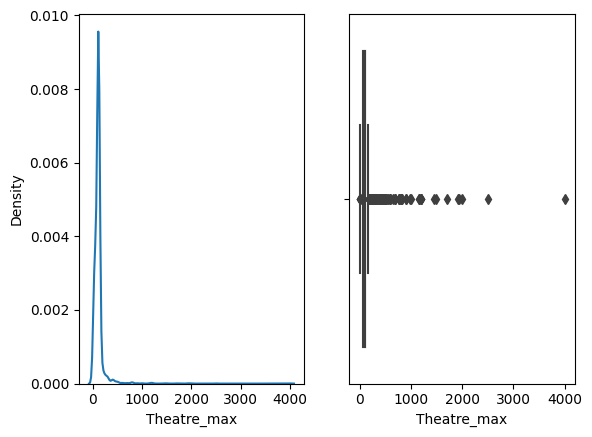

In [108]:
fig, ax = plt.subplots(1, 2)
sns.kdeplot(data=df, x='Theatre_max', ax=ax[0])
sns.boxplot(data=df, x='Theatre_max', ax=ax[1])
plt.show()


### Promoted / ticketed events

In [111]:
df['Promoted / ticketed events']

0       False
1        True
2       False
3       False
4       False
        ...  
3904    False
3905    False
3906    False
3907    False
3909    False
Name: Promoted / ticketed events, Length: 3460, dtype: bool

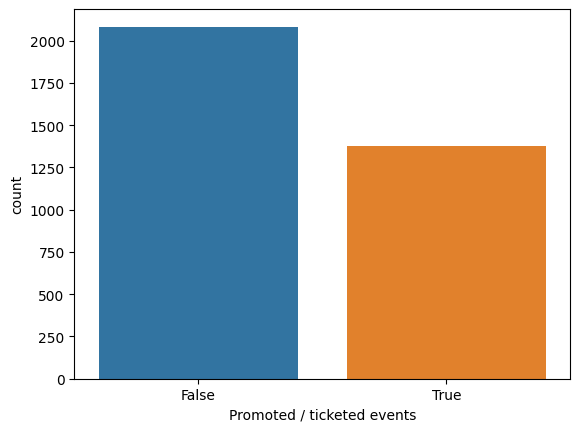

In [112]:
sns.countplot(data=df, x='Promoted / ticketed events')
plt.show()

Although the difference is small, more venues do not promote their events.

### Wheelchair acsessible

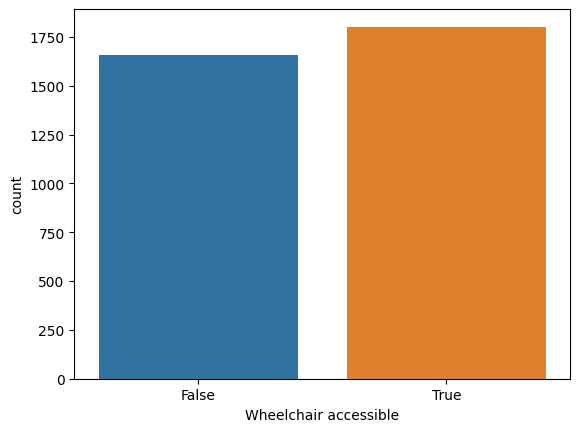

In [113]:
sns.countplot(data=df, x='Wheelchair accessible')
plt.show()

Almost an equal amount of venues have and don't have ramps. That makes it a balanced dataset or almost.

Let's tidy up the data. What are our steps?

* Drop venue_name, U-Shaped_max, Theatre_max
* Encode Loud music / events, Wi-Fi
* Separate the Wheelchair accessible column


In [ ]:
de wrangle(dataframe):
    data

In [114]:
df.drop(['venue_name', 'U-Shaped_max', 'Theatre_max'], axis=1, inplace=True)

In [117]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,Loud music / events,Venue provides alcohol,Wi-Fi,supervenue,max_standing,Promoted / ticketed events,Wheelchair accessible
0,False,0,True,False,0,False,False
1,True,1,True,False,120,True,False
2,False,0,True,False,0,False,False
3,False,0,True,False,60,False,False
4,False,0,True,False,0,False,False


In [118]:
target = df.pop('Wheelchair accessible')
target

0       False
1       False
2       False
3       False
4       False
        ...  
3904     True
3905     True
3906     True
3907     True
3909     True
Name: Wheelchair accessible, Length: 3460, dtype: bool

In [119]:
X_train, X_hold, y_train, y_hold = train_test_split(df, target, random_state=1221, train_size=.7)
X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, random_state=121, test_size=.5)

In [124]:
def assess(true_value, predicted_value):
    cm = confusion_matrix(true_value, predicted_value)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cr = classification_report(true_value, predicted_value)
    print(cm)
    # disp.plot()
    print(cr)
    
def assess_classifier(model):
    '''
    My classification model assessment function
    '''
    
    train_acc = met.accuracy_score(y_train, model.predict(X_train))
    train_bal_acc = met.balanced_accuracy_score(y_train, model.predict(X_train))
    train_f1 = met.f1_score(y_train, model.predict(X_train))
    train_recall = met.recall_score(y_train, model.predict(X_train))
    train_precision = met.precision_score(y_train, model.predict(X_train))
    
    test_acc = met.accuracy_score(y_test, model.predict(X_test))
    test_bal_acc = met.balanced_accuracy_score(y_test, model.predict(X_test))
    test_f1 = met.f1_score(y_test, model.predict(X_test))
    test_recall = met.recall_score(y_test, model.predict(X_test))
    test_precision = met.precision_score(y_test, model.predict(X_test))
    
    val_acc = met.accuracy_score(y_val, model.predict(X_val))
    val_bal_acc = met.balanced_accuracy_score(y_val, model.predict(X_val))
    val_f1 = met.f1_score(y_val, model.predict(X_val))
    val_recall = met.recall_score(y_val, model.predict(X_val))
    val_precision = met.precision_score(y_val, model.predict(X_val))
    
    dafa = pd.DataFrame({
        'Accuracy':[train_acc, test_acc, val_acc],
        'Balanced Accuracy':[train_bal_acc, test_bal_acc, val_bal_acc],
        'F1 score':[train_f1, test_f1, val_f1],
        'Recall':[train_recall, test_recall, val_recall],
        'Precision':[train_precision, test_precision, val_precision]}, 
        
        index=['Train', 'Test', 'Validation']
    )
    display(dafa)

A Decision Tree

In [125]:
base_dtc = DecisionTreeClassifier()
base_dtc.fit(X_train, y_train) 
assess_classifier(base_dtc)

,Accuracy,Balanced Accuracy,F1 score,Recall,Precision
Train,0.698183,0.695758,0.721099,0.737129,0.705751
Test,0.556840,0.558846,0.599303,0.674510,0.539185
Validation,0.576108,0.574490,0.607143,0.639098,0.578231


In [133]:
tuned_dtc = DecisionTreeClassifier(max_leaf_nodes=5, min_samples_leaf=4)
tuned_dtc.fit(X_train, y_train)
assess_classifier(tuned_dtc)

,Accuracy,Balanced Accuracy,F1 score,Recall,Precision
Train,0.586292,0.584428,0.611929,0.616225,0.607692
Test,0.583815,0.584626,0.598513,0.631373,0.568905
Validation,0.628131,0.627366,0.644567,0.657895,0.631769


Random Forest Ensemble

In [135]:
base_rfc = RandomForestClassifier()
base_rfc.fit(X_train, y_train)
assess_classifier(base_rfc)

,Accuracy,Balanced Accuracy,F1 score,Recall,Precision
Train,0.698183,0.693086,0.732332,0.780031,0.690131
Test,0.560694,0.563168,0.612245,0.705882,0.540541
Validation,0.583815,0.581236,0.627586,0.684211,0.579618


In [162]:
tuned_rfc = RandomForestClassifier(n_estimators=1000, max_samples=500,
                                   max_features=4, min_samples_leaf=.0000001)
tuned_rfc.fit(X_train, y_train)
assess_classifier(tuned_rfc)

,Accuracy,Balanced Accuracy,F1 score,Recall,Precision
Train,0.671759,0.666084,0.711014,0.762871,0.665759
Test,0.562620,0.565397,0.619765,0.725490,0.540936
Validation,0.603083,0.600902,0.639860,0.687970,0.598039


In [39]:
def assess(true_value, predicted_value):
    cm = confusion_matrix(true_value, predicted_value)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    cr = classification_report(true_value, predicted_value)
    print(cm)
    # disp.plot()
    print(cr)

In [40]:
lr = LogisticRegression(solver='saga', max_iter=10000, penalty='elasticnet', l1_ratio=0.5)

lr.fit(X_train, y_train)

print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))


0.5083092485549133
0.5043352601156069


In [91]:
def prec(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    x = (cm[0,0]/ (cm[0, 0] + cm[1, 0]))
    return x 

In [66]:

dtc = DecisionTreeClassifier(criterion='log_loss')

dtc.fit(X_train, y_train)

print(dtc.score(X_train, y_train))
print(dtc.score(X_test, y_test))


print(confusion_matrix(y_test, dtc.predict(X_test), labels=[0, 1]))
print(confusion_matrix(y_train, dtc.predict(X_train)))
print(classification_report(y_train, dtc.predict(X_train)))
print(classification_report(y_test, dtc.predict(X_test)))

0.8497109826589595
0.6213872832369942
[[228 103]
 [159 202]]
[[1237   89]
 [ 327 1115]]
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      1326
           1       0.93      0.77      0.84      1442

    accuracy                           0.85      2768
   macro avg       0.86      0.85      0.85      2768
weighted avg       0.86      0.85      0.85      2768

              precision    recall  f1-score   support

           0       0.59      0.69      0.64       331
           1       0.66      0.56      0.61       361

    accuracy                           0.62       692
   macro avg       0.63      0.62      0.62       692
weighted avg       0.63      0.62      0.62       692



In [97]:
params={
    'max_depth': [3, 5, 9, 20, 50],
    'min_samples_split':[2, 4],
    'min_samples_leaf':[1, 5, 10],
    'max_features': [2, 5, 10],
    'max_leaf_nodes':[2, 5, 10]
}

precision = make_scorer(precision_score, greater_is_better=True)
recall = make_scorer(recall_score)
pr = make_scorer(prec)
f1 = make_scorer(f1_score)

rcc = RandomizedSearchCV(estimator=dtc, param_distributions=params, n_iter=200, cv=5, scoring=f1)
rcc.fit(X_train, y_train)
assess(y_train, rcc.best_estimator_.predict(X_train))
assess(y_test, rcc.best_estimator_.predict(X_test))

[[ 539  787]
 [ 275 1167]]
              precision    recall  f1-score   support

           0       0.66      0.41      0.50      1326
           1       0.60      0.81      0.69      1442

    accuracy                           0.62      2768
   macro avg       0.63      0.61      0.60      2768
weighted avg       0.63      0.62      0.60      2768

[[129 202]
 [ 68 293]]
              precision    recall  f1-score   support

           0       0.65      0.39      0.49       331
           1       0.59      0.81      0.68       361

    accuracy                           0.61       692
   macro avg       0.62      0.60      0.59       692
weighted avg       0.62      0.61      0.59       692



In [96]:
print(precision_recall_fscore_support(y_test, rcc.best_estimator_.predict(X_test)))

(array([0.51618123, 0.83783784]), array([0.96374622, 0.17174515]), array([0.67228662, 0.28505747]), array([331, 361], dtype=int64))


In [42]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train)

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))


print(confusion_matrix(y_test, knn.predict(X_test), labels=[0, 1]))
print(confusion_matrix(y_train, knn.predict(X_train)))
print(classification_report(y_train, knn.predict(X_train)))
print(classification_report(y_test, knn.predict(X_test)))


'''
n_n = [10, 20, 30, 40, 50, 60, 70, 80, 90]
train_acc = []
test_acc = []
for n in n_n:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

plt.plot(n_n, train_acc, label='Train')
plt.plot(n_n, test_acc, label='Test')
plt.show()

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))


print(confusion_matrix(y_test, knn.predict(X_test), labels=[0, 1]))
print(confusion_matrix(y_train, knn.predict(X_train)))
print(classification_report(y_train, knn.predict(X_train)))
print(classification_report(y_test, knn.predict(X_test)))
'''

0.6842485549132948
0.6459537572254336
[[219 112]
 [133 228]]
[[988 338]
 [536 906]]
              precision    recall  f1-score   support

           0       0.65      0.75      0.69      1326
           1       0.73      0.63      0.67      1442

    accuracy                           0.68      2768
   macro avg       0.69      0.69      0.68      2768
weighted avg       0.69      0.68      0.68      2768

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       331
           1       0.67      0.63      0.65       361

    accuracy                           0.65       692
   macro avg       0.65      0.65      0.65       692
weighted avg       0.65      0.65      0.65       692



"\nn_n = [10, 20, 30, 40, 50, 60, 70, 80, 90]\ntrain_acc = []\ntest_acc = []\nfor n in n_n:\n    knn = KNeighborsClassifier(n_neighbors=n)\n    knn.fit(X_train, y_train)\n    train_acc.append(knn.score(X_train, y_train))\n    test_acc.append(knn.score(X_test, y_test))\n\nplt.plot(n_n, train_acc, label='Train')\nplt.plot(n_n, test_acc, label='Test')\nplt.show()\n\nprint(knn.score(X_train, y_train))\nprint(knn.score(X_test, y_test))\n\n\nprint(confusion_matrix(y_test, knn.predict(X_test), labels=[0, 1]))\nprint(confusion_matrix(y_train, knn.predict(X_train)))\nprint(classification_report(y_train, knn.predict(X_train)))\nprint(classification_report(y_test, knn.predict(X_test)))\n"

In [98]:
param = {'n_neighbors': [77, 78, 79, 80, 81],
         'leaf_size':[9]}
rcv = GridSearchCV(estimator=knn, param_grid=param, cv=5, scoring=f1)

rcv.fit(X_train, y_train)

assess(y_train, rcv.best_estimator_.predict(X_train))
assess(y_test, rcv.best_estimator_.predict(X_test))

[[825 501]
 [489 953]]
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      1326
           1       0.66      0.66      0.66      1442

    accuracy                           0.64      2768
   macro avg       0.64      0.64      0.64      2768
weighted avg       0.64      0.64      0.64      2768

[[209 122]
 [119 242]]
              precision    recall  f1-score   support

           0       0.64      0.63      0.63       331
           1       0.66      0.67      0.67       361

    accuracy                           0.65       692
   macro avg       0.65      0.65      0.65       692
weighted avg       0.65      0.65      0.65       692



In [99]:
rcv.best_params_

{'leaf_size': 9, 'n_neighbors': 81}

In [43]:

rfc = RandomForestClassifier(n_estimators=1000, max_depth=9, max_features='log2', max_leaf_nodes=10)

rfc.fit(X_train, y_train)

print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))



print(confusion_matrix(y_test, rfc.predict(X_test), labels=[0, 1]))
print(confusion_matrix(y_train, rfc.predict(X_train)))
print(classification_report(y_train, rfc.predict(X_train)))
print(classification_report(y_test, rfc.predict(X_test)))

0.6676300578034682
0.6488439306358381
[[206 125]
 [118 243]]
[[852 474]
 [446 996]]
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1326
           1       0.68      0.69      0.68      1442

    accuracy                           0.67      2768
   macro avg       0.67      0.67      0.67      2768
weighted avg       0.67      0.67      0.67      2768

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       331
           1       0.66      0.67      0.67       361

    accuracy                           0.65       692
   macro avg       0.65      0.65      0.65       692
weighted avg       0.65      0.65      0.65       692



In [101]:
param = {'max_depth':[1, 5, 9],
         'max_leaf_nodes':[5, 10]}
rcv = RandomizedSearchCV(estimator=rfc, param_distributions=param, n_iter=5, scoring=f1, cv=3)

rcv.fit(X_train, y_train)

assess(y_train, rcv.predict(X_train))
assess(y_test, rcv.predict(X_test))

[[ 839  487]
 [ 434 1008]]
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      1326
           1       0.67      0.70      0.69      1442

    accuracy                           0.67      2768
   macro avg       0.67      0.67      0.67      2768
weighted avg       0.67      0.67      0.67      2768

[[205 126]
 [115 246]]
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       331
           1       0.66      0.68      0.67       361

    accuracy                           0.65       692
   macro avg       0.65      0.65      0.65       692
weighted avg       0.65      0.65      0.65       692



In [102]:

ada = AdaBoostClassifier(base_estimator=rfc, n_estimators=20)

ada.fit(X_train, y_train)

print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))


print(confusion_matrix(y_test, ada.predict(X_test), labels=[1, 0]))
print(confusion_matrix(y_train, ada.predict(X_train)))
print(classification_report(y_train, ada.predict(X_train), labels=[1, 0]))
print(classification_report(y_test, ada.predict(X_test)))

0.7319364161849711
0.6546242774566474
[[240 121]
 [118 213]]
[[ 993  333]
 [ 409 1033]]
              precision    recall  f1-score   support

           1       0.76      0.72      0.74      1442
           0       0.71      0.75      0.73      1326

    accuracy                           0.73      2768
   macro avg       0.73      0.73      0.73      2768
weighted avg       0.73      0.73      0.73      2768

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       331
           1       0.67      0.66      0.67       361

    accuracy                           0.65       692
   macro avg       0.65      0.65      0.65       692
weighted avg       0.65      0.65      0.65       692



In [46]:


svc = SVC(C=10, gamma=.005)

svc.fit(X_train, y_train)

print(svc.score(X_train, y_train))
print(svc.score(X_test, y_test))

print(confusion_matrix(y_test, svc.predict(X_test), labels=[1, 0]))
print(confusion_matrix(y_train, svc.predict(X_train)))
print(classification_report(y_train, svc.predict(X_train)))
print(classification_report(y_test, svc.predict(X_test), labels=[1,0]))

0.7297687861271677
0.6315028901734104
[[215 146]
 [109 222]]
[[1056  270]
 [ 478  964]]
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1326
           1       0.78      0.67      0.72      1442

    accuracy                           0.73      2768
   macro avg       0.73      0.73      0.73      2768
weighted avg       0.74      0.73      0.73      2768

              precision    recall  f1-score   support

           1       0.66      0.60      0.63       361
           0       0.60      0.67      0.64       331

    accuracy                           0.63       692
   macro avg       0.63      0.63      0.63       692
weighted avg       0.63      0.63      0.63       692



In [112]:

pg = {
    'C':[1, 10, 15, 20],
    'degree':[3],
    'gamma':[0.05, 0.1, .9]
    
}

sv = GridSearchCV(estimator=svc, param_grid=pg, cv=5, scoring=f1)
sv.fit(X_train, y_train)

assess(y_train, sv.best_estimator_.predict(X_train))
assess(y_test, sv.best_estimator_.predict(X_test))
print(sv.best_params_)

[[1194  132]
 [ 299 1143]]
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1326
           1       0.90      0.79      0.84      1442

    accuracy                           0.84      2768
   macro avg       0.85      0.85      0.84      2768
weighted avg       0.85      0.84      0.84      2768

[[188 143]
 [113 248]]
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       331
           1       0.63      0.69      0.66       361

    accuracy                           0.63       692
   macro avg       0.63      0.63      0.63       692
weighted avg       0.63      0.63      0.63       692

{'C': 1, 'degree': 3, 'gamma': 0.9}


In [113]:
lsvc = LinearSVC(max_iter=5000)

lsvc.fit(X_train, y_train)

print(lsvc.score(X_train, y_train))
print(lsvc.score(X_test, y_test))

print(confusion_matrix(y_test, lsvc.predict(X_test), labels=[0, 1]))
print(confusion_matrix(y_train, lsvc.predict(X_train)))
print(classification_report(y_train, lsvc.predict(X_train)))
print(classification_report(y_test, lsvc.predict(X_test)))

0.6054913294797688
0.6054913294797688
[[210 121]
 [152 209]]
[[861 465]
 [627 815]]
              precision    recall  f1-score   support

           0       0.58      0.65      0.61      1326
           1       0.64      0.57      0.60      1442

    accuracy                           0.61      2768
   macro avg       0.61      0.61      0.61      2768
weighted avg       0.61      0.61      0.61      2768

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       331
           1       0.63      0.58      0.60       361

    accuracy                           0.61       692
   macro avg       0.61      0.61      0.61       692
weighted avg       0.61      0.61      0.61       692



c:\Users\Tosin OLUYEMII\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
RandomForestClassifier()